# I will use this notebook to optimize my random forest model.

This section will only used the balanced weighting to deal with class-imbalance. I will try to deal with other methods for tackling class imbalance in another book at another time.

In [1]:
#STEP 1: Load modules
%pylab inline
import pandas as pd
import contributions
import votes
import bills
import sqlCommands
from peoplefinder import PeopleFinder
from operator import attrgetter
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from tqdm import tqdm
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
import random
import scipy as sc

#define function that generates plot of F1-score with varying parameters.
def F1plot(f,x,xtitle, islog):
    plt.plot(x,f*100.)
    if islog:
        plt.xscale('log')
    plt.title('F1 Score', fontsize=20)
    plt.xlabel(xtitle, fontsize=16)
    plt.ylabel('F1 Score (%)', fontsize=16)
    
def accplot(y_accs,x,xtitle, islog):
    plt.plot(x,y_accs*100.)
    if islog:
        plt.xscale('log')
    plt.title('Accuracy', fontsize=20)
    plt.xlabel(xtitle, fontsize=16)
    plt.ylabel('Accuracy (%)', fontsize=16)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#set up postgresql engine
dbname = 'legislatr'
engine = sqlCommands.get_engine(dbname)

In [3]:
#STEP 2: Load features
#read in the subject feature array
query = "SELECT * FROM features_subs WHERE final_result = 0 OR final_result = 1;"
feat_subs = pd.read_sql_query(query,engine)
#read in the legislator feature array
query = "SELECT * FROM features_legis WHERE final_result = 0 OR final_result = 1;"
feat_legis = pd.read_sql_query(query,engine)
#read in the committee feature array
query = "SELECT * FROM features_comms WHERE final_result = 0 OR final_result = 1;"
feat_comms = pd.read_sql_query(query,engine)

#fuse dataframes
feat = pd.concat([feat_subs,feat_legis.drop(['bill_number','bill_type','index','result','status','final_result','num_amends','congress'],axis=1),
                 feat_comms.drop(['bill_number','bill_type','index','result','status','final_result','num_amends','congress'],axis=1)],axis=1)

In [4]:
#STEP 3: Create train (60%), CV (20%), and test (20%) sets.

#randomize input
data = feat.iloc[np.random.permutation(len(feat))]

indlen = feat['index'].size
trlen = int(indlen*0.6) #training set length
print(trlen)
cvlen = int((indlen-trlen)*0.5) #CV set length
print(cvlen)
testlen = indlen - trlen - cvlen #test set length
print(testlen)

#create training set
tr_data = data.iloc[0:trlen]
tr_data_Y = (tr_data.as_matrix(columns=['final_result'])).flatten()
tr_data = tr_data.drop(['bill_number','bill_type','index','result','status','final_result','congress'],axis=1)
tr_data_X = tr_data.as_matrix()
print(tr_data_X.shape)
print(tr_data_Y.shape)

#create CV set
CV_data = data.iloc[trlen:cvlen+trlen]
CV_data_Y = (CV_data.as_matrix(columns=['final_result'])).flatten()
CV_data = CV_data.drop(['bill_number','bill_type','index','result','status','final_result','congress'],axis=1)
CV_data_X = CV_data.as_matrix()
print(CV_data_X.shape)
print(CV_data_Y.shape)

#create testing set
test_data = data.iloc[cvlen+trlen:-1]
test_data_Y = (test_data.as_matrix(columns=['final_result'])).flatten()
test_data = test_data.drop(['bill_number','bill_type','index','result','status','final_result','congress'],axis=1)
test_data_X = test_data.as_matrix()
print(test_data_X.shape)
print(test_data_Y.shape)

18094
6032
6032
(18094, 1317)
(18094,)
(6032, 1317)
(6032,)
(6031, 1317)
(6031,)


### STEP 4: Choose model with best F1-score.

----------------------
Min Samples Split =  2.0
Accuracy =  0.9701591511936339
Precision =  0.6111111111111112
Recall =  0.3701923076923077
F1-Score =  0.46107784431137727
----------------------
Min Samples Split =  4.0
Accuracy =  0.968998673740053
Precision =  0.5724137931034483
Recall =  0.39903846153846156
F1-Score =  0.4702549575070822
----------------------
Min Samples Split =  8.0
Accuracy =  0.9699933687002652
Precision =  0.5859872611464968
Recall =  0.4423076923076923
F1-Score =  0.5041095890410958
----------------------
Min Samples Split =  16.0
Accuracy =  0.968501326259947
Precision =  0.5511363636363636
Recall =  0.46634615384615385
F1-Score =  0.5052083333333334
----------------------
Min Samples Split =  32.0
Accuracy =  0.9661803713527851
Precision =  0.5093457943925234
Recall =  0.5240384615384616
F1-Score =  0.5165876777251186
----------------------
Min Samples Split =  64.0
Accuracy =  0.9602122015915119
Precision =  0.43846153846153846
Recall =  0.5480769230769231


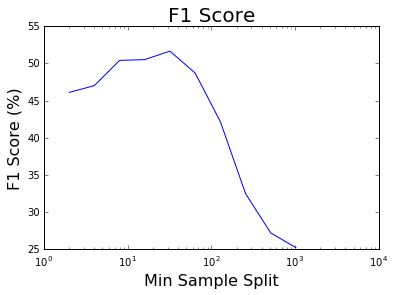

In [5]:
#optimize number of splits
base = 2. #base for numbers
exp = np.arange(10)+1. #exponent for base
val = base**exp #values to be tested
recs = list() #all recalls
prec = list() #all precisions
accs = list() #all accuracies
fscr = list() #all F1-scores

#loop through forests
for v in val:
    print('----------------------')
    print('Min Samples Split = ',v)
    forest = RandomForestClassifier(n_estimators = 100,max_depth = 32,
                                    max_features='sqrt',class_weight='balanced',min_samples_split=v)
    forest = forest.fit(tr_data_X,tr_data_Y)
    Z =forest.predict(CV_data_X)

    #set up variables
    acc = 0 #accuracy
    true_pos = 0.
    false_pos = 0.
    true_neg = 0.
    false_neg = 0.
    final = 0.

    #get parameters for statistics
    for i in range(0,len(Z)):
        if Z[i] == CV_data_Y[i]: #mark correct answers
            acc = acc + 1.
        if (Z[i] == 1) and (CV_data_Y[i] == 1): #mark true positives
            true_pos = true_pos + 1.
        if (Z[i] == 1) and (CV_data_Y[i] == 0): #mark false positives
            false_pos = false_pos + 1.
        if (Z[i] == 0) and (CV_data_Y[i] == 1): #mark false negatives
            false_neg = false_neg + 1.
        if (Z[i] == 0) and (CV_data_Y[i] == 0): #mark true negatives
            true_neg = true_neg + 1.
    #calculate Accuracy
    final = acc/len(Z)
    print('Accuracy = ',final)
    accs.append(final)

    #calculate Precision
    pre = true_pos/(true_pos+false_pos)
    print('Precision = ',pre)
    prec.append(pre)
    
    #calculate Recall
    rec = true_pos/(true_pos+false_neg)
    print('Recall = ',rec)
    recs.append(rec)
    
    #calculate F1-Score
    f1 = 2*((rec*pre)/(rec+pre))
    print('F1-Score = ',f1)
    fscr.append(f1)

y_accs = np.asarray(accs)
y_prec = np.asarray(prec)
y_recs = np.asarray(recs)
y_fscr = np.asarray(fscr)

F1plot(y_fscr,val,'Min Sample Split',True)


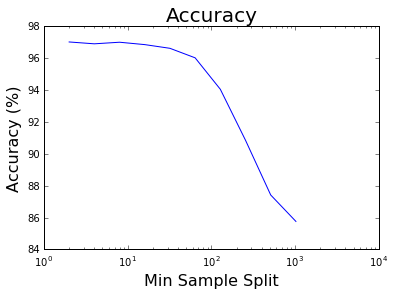

In [6]:
accplot(y_accs,val,'Min Sample Split',True)

Best Min Sample Split is: 32

----------------------
Max Depth =  2.0
Accuracy =  0.8861074270557029
Precision =  0.16596931659693165
Recall =  0.5721153846153846
F1-Score =  0.25729729729729733
----------------------
Max Depth =  4.0
Accuracy =  0.9227453580901857
Precision =  0.24705882352941178
Recall =  0.6057692307692307
F1-Score =  0.350974930362117
----------------------
Max Depth =  8.0
Accuracy =  0.9303713527851459
Precision =  0.2675438596491228
Recall =  0.5865384615384616
F1-Score =  0.3674698795180723
----------------------
Max Depth =  16.0
Accuracy =  0.9537466843501327
Precision =  0.38127090301003347
Recall =  0.5480769230769231
F1-Score =  0.44970414201183434
----------------------
Max Depth =  32.0
Accuracy =  0.9655172413793104
Precision =  0.5
Recall =  0.5192307692307693
F1-Score =  0.509433962264151
----------------------
Max Depth =  64.0
Accuracy =  0.9688328912466844
Precision =  0.5531914893617021
Recall =  0.5
F1-Score =  0.5252525252525252
----------------------
Max Depth =  128.0
Accu

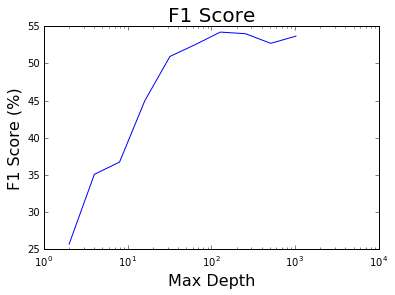

In [7]:
#optimize tree depth
base = 2. #base for numbers
exp = np.arange(10)+1. #exponent for base
val = base**exp #values to be tested
recs = list() #all recalls
prec = list() #all precisions
accs = list() #all accuracies
fscr = list() #all F1-scores

#loop through forests
for v in val:
    print('----------------------')
    print('Max Depth = ',v)
    forest = RandomForestClassifier(n_estimators = 100, max_depth = v, max_features='sqrt',class_weight='balanced',min_samples_split=32)
    forest = forest.fit(tr_data_X,tr_data_Y)
    Z =forest.predict(CV_data_X)

    #set up variables
    acc = 0 #accuracy
    true_pos = 0.
    false_pos = 0.
    true_neg = 0.
    false_neg = 0.
    final = 0.

    #get parameters for statistics
    for i in range(0,len(Z)):
        if Z[i] == CV_data_Y[i]: #mark correct answers
            acc = acc + 1.
        if (Z[i] == 1) and (CV_data_Y[i] == 1): #mark true positives
            true_pos = true_pos + 1.
        if (Z[i] == 1) and (CV_data_Y[i] == 0): #mark false positives
            false_pos = false_pos + 1.
        if (Z[i] == 0) and (CV_data_Y[i] == 1): #mark false negatives
            false_neg = false_neg + 1.
        if (Z[i] == 0) and (CV_data_Y[i] == 0): #mark true negatives
            true_neg = true_neg + 1.

    #calculate Accuracy
    final = acc/len(Z)
    print('Accuracy = ',final)
    accs.append(final)

    #calculate Precision
    pre = true_pos/(true_pos+false_pos)
    print('Precision = ',pre)
    prec.append(pre)
    
    #calculate Recall
    rec = true_pos/(true_pos+false_neg)
    print('Recall = ',rec)
    recs.append(rec)
    
    #calculate F1-Score
    f1 = 2*((rec*pre)/(rec+pre))
    print('F1-Score = ',f1)
    fscr.append(f1)

y_accs = np.asarray(accs)
y_prec = np.asarray(prec)
y_recs = np.asarray(recs)
y_fscr = np.asarray(fscr)

F1plot(y_fscr,val,'Max Depth',True)

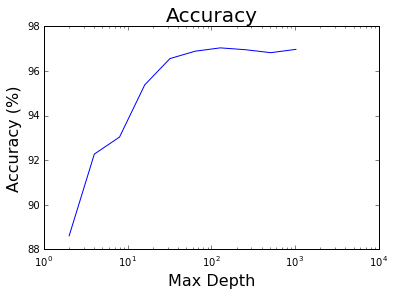

In [8]:
accplot(y_accs,val,'Max Depth',True)

Best Max Depth is: 128

----------------------
Min Samples Leaf =  1.0
Accuracy =  0.968998673740053
Precision =  0.5544041450777202
Recall =  0.5144230769230769
F1-Score =  0.5336658354114713
----------------------
Min Samples Leaf =  2.0
Accuracy =  0.9645225464190982
Precision =  0.48760330578512395
Recall =  0.5673076923076923
F1-Score =  0.5244444444444445
----------------------
Min Samples Leaf =  4.0
Accuracy =  0.9530835543766578
Precision =  0.3867069486404834
Recall =  0.6153846153846154
F1-Score =  0.47495361781076073
----------------------
Min Samples Leaf =  8.0
Accuracy =  0.9237400530503979
Precision =  0.2622641509433962
Recall =  0.6682692307692307
F1-Score =  0.3766937669376694
----------------------
Min Samples Leaf =  16.0
Accuracy =  0.8846153846153846
Precision =  0.18556701030927836
Recall =  0.6923076923076923
F1-Score =  0.29268292682926833
----------------------
Min Samples Leaf =  32.0
Accuracy =  0.8390251989389921
Precision =  0.14111006585136407
Recall =  0.7211538461538461
F1-Sc

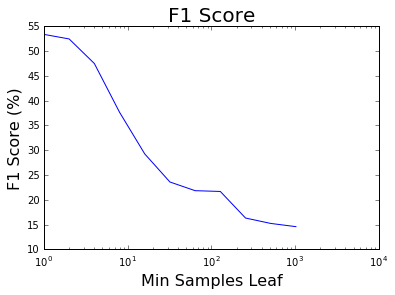

In [9]:
#optimize minimum number of samples per leaf
base = 2. #base for numbers
exp = np.arange(11) #exponent for base #note that in this case the default value was 1, so we are starting at 1.
val = base**exp #values to be tested
recs = list() #all recalls
prec = list() #all precisions
accs = list() #all accuracies
fscr = list() #all F1-scores

#loop through forests
for v in val:
    print('----------------------')
    print('Min Samples Leaf = ',v)
    forest = RandomForestClassifier(n_estimators = 100, max_depth = 128, min_samples_leaf = v,
                                    max_features='sqrt',class_weight='balanced',min_samples_split=32)
    forest = forest.fit(tr_data_X,tr_data_Y)
    Z =forest.predict(CV_data_X)

    #set up variables
    acc = 0 #accuracy
    true_pos = 0.
    false_pos = 0.
    true_neg = 0.
    false_neg = 0.
    final = 0.

    #get parameters for statistics
    for i in range(0,len(Z)):
        if Z[i] == CV_data_Y[i]: #mark correct answers
            acc = acc + 1.
        if (Z[i] == 1) and (CV_data_Y[i] == 1): #mark true positives
            true_pos = true_pos + 1.
        if (Z[i] == 1) and (CV_data_Y[i] == 0): #mark false positives
            false_pos = false_pos + 1.
        if (Z[i] == 0) and (CV_data_Y[i] == 1): #mark false negatives
            false_neg = false_neg + 1.
        if (Z[i] == 0) and (CV_data_Y[i] == 0): #mark true negatives
            true_neg = true_neg + 1.

    #calculate Accuracy
    final = acc/len(Z)
    print('Accuracy = ',final)
    accs.append(final)

    #calculate Precision
    pre = true_pos/(true_pos+false_pos)
    print('Precision = ',pre)
    prec.append(pre)
    
    #calculate Recall
    rec = true_pos/(true_pos+false_neg)
    print('Recall = ',rec)
    recs.append(rec)
    
    #calculate F1-Score
    f1 = 2*((rec*pre)/(rec+pre))
    print('F1-Score = ',f1)
    fscr.append(f1)

y_accs = np.asarray(accs)
y_prec = np.asarray(prec)
y_recs = np.asarray(recs)
y_fscr = np.asarray(fscr)

F1plot(y_fscr,val,'Min Samples Leaf',True)

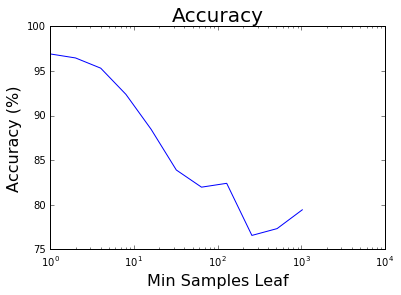

In [10]:
accplot(y_accs,val,'Min Samples Leaf',True)

Best Min Samples Leaf is: 1

----------------------
Number of trees =  50.0
Accuracy =  0.9651856763925729
Precision =  0.4955357142857143
Recall =  0.5336538461538461
F1-Score =  0.513888888888889
----------------------
Number of trees =  100.0
Accuracy =  0.9655172413793104
Precision =  0.5
Recall =  0.5480769230769231
F1-Score =  0.5229357798165137
----------------------
Number of trees =  150.0
Accuracy =  0.9650198938992043
Precision =  0.4928909952606635
Recall =  0.5
F1-Score =  0.4964200477326969
----------------------
Number of trees =  200.0
Accuracy =  0.9660145888594165
Precision =  0.5070422535211268
Recall =  0.5192307692307693
F1-Score =  0.513064133016627
----------------------
Number of trees =  250.0
Accuracy =  0.9666777188328912
Precision =  0.5164319248826291
Recall =  0.5288461538461539
F1-Score =  0.5225653206650832
----------------------
Number of trees =  300.0
Accuracy =  0.9663461538461539
Precision =  0.5118483412322274
Recall =  0.5192307692307693
F1-Score =  0.5155131264916468
-------

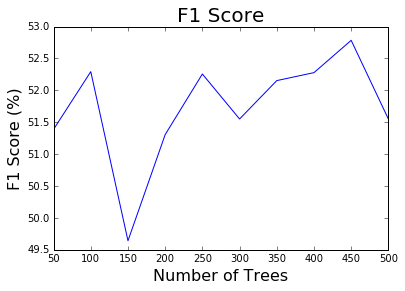

In [11]:
#optimize number of trees
base = 50. #base for numbers
exp = np.arange(10)+1 #exponent for base #note that in this case the default value was 1, so we are starting at 1.
val = base*exp #values to be tested #in this case expect linear to do better.
recs = list() #all recalls
prec = list() #all precisions
accs = list() #all accuracies
fscr = list() #all F1-scores

#loop through forests
for v in val:
    print('----------------------')
    print('Number of trees = ',v)
    forest = RandomForestClassifier(n_estimators = v.astype(int), max_depth = 32, min_samples_leaf = 1,
                                    max_features='sqrt',class_weight='balanced',min_samples_split=32)
    forest = forest.fit(tr_data_X,tr_data_Y)
    Z =forest.predict(CV_data_X)

    #set up variables
    acc = 0 #accuracy
    true_pos = 0.
    false_pos = 0.
    true_neg = 0.
    false_neg = 0.
    final = 0.

    #get parameters for statistics
    for i in range(0,len(Z)):
        if Z[i] == CV_data_Y[i]: #mark correct answers
            acc = acc + 1.
        if (Z[i] == 1) and (CV_data_Y[i] == 1): #mark true positives
            true_pos = true_pos + 1.
        if (Z[i] == 1) and (CV_data_Y[i] == 0): #mark false positives
            false_pos = false_pos + 1.
        if (Z[i] == 0) and (CV_data_Y[i] == 1): #mark false negatives
            false_neg = false_neg + 1.
        if (Z[i] == 0) and (CV_data_Y[i] == 0): #mark true negatives
            true_neg = true_neg + 1.

    #calculate Accuracy
    final = acc/len(Z)
    print('Accuracy = ',final)
    accs.append(final)

    #calculate Precision
    pre = true_pos/(true_pos+false_pos)
    print('Precision = ',pre)
    prec.append(pre)
    
    #calculate Recall
    rec = true_pos/(true_pos+false_neg)
    print('Recall = ',rec)
    recs.append(rec)
    
    #calculate F1-Score
    f1 = 2*((rec*pre)/(rec+pre))
    print('F1-Score = ',f1)
    fscr.append(f1)

y_accs = np.asarray(accs)
y_prec = np.asarray(prec)
y_recs = np.asarray(recs)
y_fscr = np.asarray(fscr)

F1plot(y_fscr,val,'Number of Trees',False)

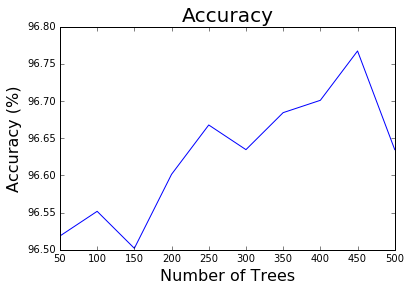

In [13]:
accplot(y_accs,val,'Number of Trees',False)

Best number of trees: 400

100%|██████████| 801/801 [00:20<00:00, 39.91it/s]


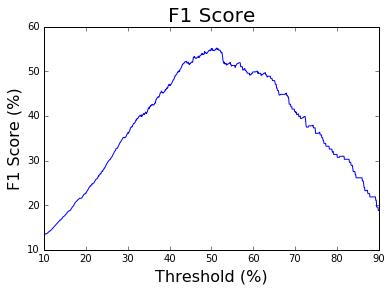

In [14]:
#Optimize threshold.

#train best forest
forest = RandomForestClassifier(n_estimators = 225, max_depth = 128, min_samples_leaf = 1,
                                max_features='sqrt',class_weight='balanced',min_samples_split=32)
forest = forest.fit(tr_data_X,tr_data_Y)
P =forest.predict_proba(CV_data_X)

recs = list() #all recalls
prec = list() #all precisions
accs = list() #all accuracies
fscr = list() #all F1-scores

#loop over thresholds
val = (np.arange(801)+100)/1000.
for v in tqdm(val):
    Z = list()
    for i in range(0,len(P)):
        Z.append(sc.greater(P[i][1],v).astype(int)) #returns array where prob of passing is greater than threshold.
    #Z = Z.astype(int)
    #set up variables
    acc = 0 #accuracy
    true_pos = 0.
    false_pos = 0.
    true_neg = 0.
    false_neg = 0.
    final = 0.

    #get parameters for statistics
    for i in range(0,len(Z)):
        if Z[i] == CV_data_Y[i]: #mark correct answers
            acc = acc + 1.
        if (Z[i] == 1) and (CV_data_Y[i] == 1): #mark true positives
            true_pos = true_pos + 1.
        if (Z[i] == 1) and (CV_data_Y[i] == 0): #mark false positives
            false_pos = false_pos + 1.
        if (Z[i] == 0) and (CV_data_Y[i] == 1): #mark false negatives
            false_neg = false_neg + 1.
        if (Z[i] == 0) and (CV_data_Y[i] == 0): #mark true negatives
            true_neg = true_neg + 1.

    #calculate Accuracy
    final = acc/len(Z)
    #print('Accuracy = ',final)
    accs.append(final)

    #calculate Precision
    pre = true_pos/(true_pos+false_pos)
    #print('Precision = ',pre)
    prec.append(pre)
    
    #calculate Recall
    rec = true_pos/(true_pos+false_neg)
    #print('Recall = ',rec)
    recs.append(rec)
    
    #calculate F1-Score
    f1 = 2*((rec*pre)/(rec+pre))
    #print('F1-Score = ',f1)
    fscr.append(f1)

y_accs = np.asarray(accs)
y_prec = np.asarray(prec)
y_recs = np.asarray(recs)
y_fscr = np.asarray(fscr)

F1plot(y_fscr,val*100,'Threshold (%)',False)

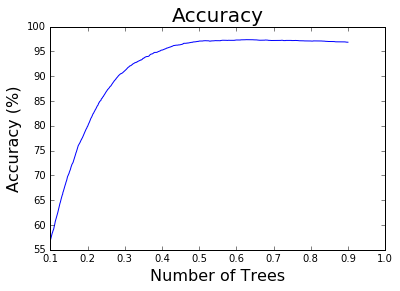

In [16]:
accplot(y_accs,val,'Number of Trees',False)

Correct threshold is set to 50%

In [17]:
#STEP 5: Create code that generates ROC curve.
#For this use training and CV sets together
#create training set
roc_data = data.iloc[0:trlen+cvlen]
roc_data_Y = (roc_data.as_matrix(columns=['final_result'])).flatten()
roc_data = roc_data.drop(['bill_number','bill_type','index','result','status','final_result','congress'],axis=1)
roc_data_X = roc_data.as_matrix()
print(roc_data_X.shape)
print(roc_data_Y.shape)

(24126, 1317)
(24126,)


In [81]:
#train best forest
forest = RandomForestClassifier(n_estimators = 400, max_depth = 128, min_samples_leaf = 1,
                                max_features='sqrt',class_weight='balanced',min_samples_split=32)
forest = forest.fit(roc_data_X,roc_data_Y)
Z = forest.predict(test_data_X)

acc = 0 #accuracy
true_pos = 0.
false_pos = 0.
true_neg = 0.
false_neg = 0.
final = 0.

#get parameters for statistic
for i in range(0,len(Z)):
    if Z[i] == test_data_Y[i]: #mark correct answers
        acc = acc + 1.
    if (Z[i] == 1) and (test_data_Y[i] == 1): #mark true positives
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i] == 1): #mark false negatives
        false_neg = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i] == 0): #mark false positives
        false_pos = false_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i] == 0): #mark true negatives
        true_neg = true_neg + 1.
        
        
#calculate Accuracy
final = acc/len(Z)
print('Accuracy = ',final)

#calculate Precision
pre = true_pos/(true_pos+false_pos)
print('Precision = ',pre)
    
#calculate Recall
rec = true_pos/(true_pos+false_neg)
print('Recall = ',rec)
    
#calculate F1-Score
f1 = 2*((rec*pre)/(rec+pre))
print('F1-Score = ',f1)

#print result parameters
print('True Pos = ',true_pos)
print('False Pos = ',false_pos)
print('False Neg = ',false_neg)
print('True Neg = ',true_neg)


#get ROC curve data
P =forest.predict_proba(test_data_X)

fpos = list() #all false positives
tpos = list() #all true positives
fneg = list() #all false negatives
tneg = list() #all true negatives

#loop over thresholds
val = np.arange(101)/100.
for v in tqdm(val):
    Z = list()
    for i in range(0,len(P)):
        Z.append(sc.greater_equal(P[i][1],v).astype(int)) #returns array where prob of passing is greater than threshold.
    #Z = Z.astype(int)
    #set up variables
    true_pos = 0.
    false_pos = 0.
    false_neg = 0.
    true_neg = 0.

    #get parameters for statistics
    for i in range(0,len(Z)):
        if (Z[i] == 1) and (test_data_Y[i] == 1): #mark true positives
            true_pos = true_pos + 1.
        if (Z[i] == 0) and (test_data_Y[i] == 1): #mark false negatives
            false_neg = false_pos + 1.
        if (Z[i] == 1) and (test_data_Y[i] == 0): #mark false positives
            false_pos = false_pos + 1.
        if (Z[i] == 0) and (test_data_Y[i] == 0): #mark true negatives
            true_neg = true_neg + 1.

    fpos.append(false_pos)
    tpos.append(true_pos)
    fneg.append(false_neg)
    tneg.append(true_neg)

Accuracy =  0.9645166639031669
Precision =  0.5116279069767442
Recall =  0.5092592592592593
F1-Score =  0.5104408352668214
True Pos =  110.0
False Pos =  105.0
False Neg =  106.0
True Neg =  5707.0


100%|██████████| 101/101 [00:02<00:00, 46.04it/s]


# Because true negatives dwarf the number of true positives, ROC is not an appropriate metric. Rather, I should plot precision versus recall.

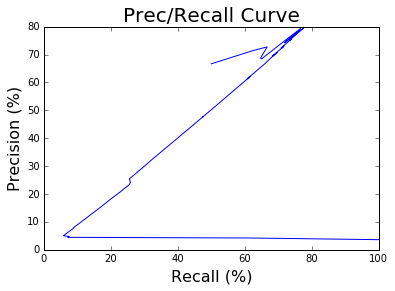

In [82]:
#plot precision/recall curve
ar_tpos = np.asarray(tpos)
ar_fpos = np.asarray(fpos)
ar_tneg = np.asarray(tneg)
ar_fneg = np.asarray(fneg)

#calculate Precision
pre = (ar_tpos/(ar_tpos+ar_fpos))*100.
    
#calculate Recall
rec = (ar_tpos/(ar_tpos+ar_fneg))*100.


plt.plot(rec,pre,color='blue')
plt.title('Prec/Recall Curve', fontsize=20)
plt.xlabel('Recall (%)', fontsize=16)
plt.ylabel('Precision (%)', fontsize=16)
#plt.plot([0,1],[0,1],linestyle='--',color='black')

In [76]:
print(rec[50:100])
print(ar_tpos)
print(ar_fneg)
print(ar_fpos)

[ 6.17604618  6.21190131  6.25365283  6.29226698  6.33323468  6.37473935
  6.42449715  6.46330414  6.51247718  6.55838186  6.58866995  6.62949195
  6.68123634  6.72955975  6.80012711  6.81452909  6.86528497  6.91680261
  6.96452037  7.02451955  7.09504685  7.15732613  7.19864177  7.24291083
  7.31034483  7.36622655  7.41518013  7.47268241  7.50974141  7.54985755
  7.60401722  7.67559739  7.71189523  7.77696258  7.84894484  7.92523364
  7.99095364  8.04248862  8.09160305  8.13507291  8.19482026  8.24581875
  8.30070478  8.09359417  8.16247582  8.18394388  8.21218075  8.26086957
  8.27695981  8.31659301]
[ 219.  219.  219. ...,    0.    0.    0.]
[ 0.  0.  0. ...,  1.  1.  1.]
[ 5812.  5332.  5250. ...,     0.     0.     0.]


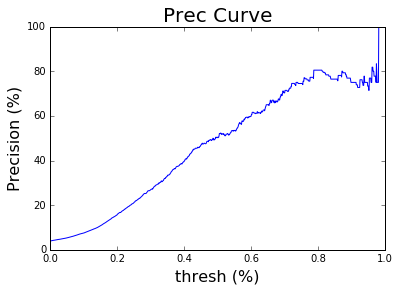

In [67]:
plt.plot(val,pre,color='blue')
plt.title('Prec Curve', fontsize=20)
plt.xlabel('thresh (%)', fontsize=16)
plt.ylabel('Precision (%)', fontsize=16)

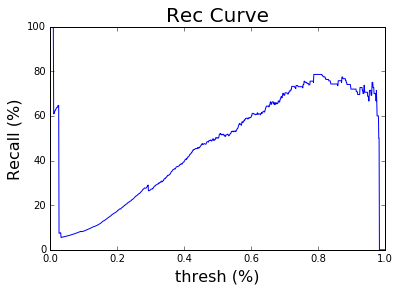

In [68]:
plt.plot(val,rec,color='blue')
plt.title('Rec Curve', fontsize=20)
plt.xlabel('thresh (%)', fontsize=16)
plt.ylabel('Recall (%)', fontsize=16)

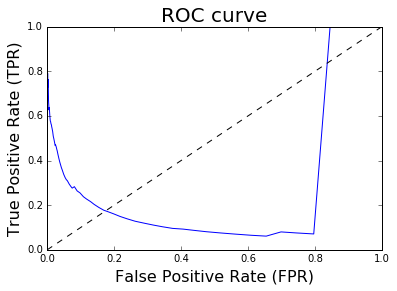

In [54]:
#plot ROC curve
ar_tpos = np.asarray(tpos)
ar_fpos = np.asarray(fpos)
ar_tneg = np.asarray(tneg)
ar_fneg = np.asarray(fneg)

#TPR = list()
#FPR = list()
#for i in range(0,len(ar_tpos)):
    #if ar_tpos[i] == 0:
    #    if ar_fneg[i] == 0:
    #        TPR.append(0.)
    #    else:
    #        TPR.append(1.)
    #else:
    #    TPR.append(ar_tpos[i]/(ar_tpos[i]+ar_fneg[i]))
    #if ar_fpos[i] == 0:
    #    if ar_tneg[i] == 0:
    #        FPR.append(0.)
    #    else:
    #        FPR.append(1.)
    #else:
    #    FPR.append(ar_fpos[i]/(ar_fpos[i]+ar_tneg[i]))
TPR = ar_tpos/(ar_tpos+ar_fneg)  #true positive rate
FPR = ar_fpos/(ar_fpos+ar_tneg)  #false positive rate
#TPR = np.asarray(TPR)
#FPR = np.asarray(FPR)
toplot = list(zip(TPR,FPR))
toplot_sort = sorted(toplot, key=lambda toplot: toplot[1])
TPR = list()
FPR = list()
for tup in toplot_sort:
    TPR.append(tup[0])
    FPR.append(tup[1])

plt.plot(FPR,TPR,color='blue')
plt.title('ROC curve', fontsize=20)
plt.xlabel('False Positive Rate (FPR)', fontsize=16)
plt.ylabel('True Positive Rate (TPR)', fontsize=16)
plt.plot([0,1],[0,1],linestyle='--',color='black')

In [63]:
print(TPR[80:90])
print(FPR[80:90])


[0.17047451669595781, 0.16134316134316135, 0.14943396226415095, 0.13877266387726639, 0.12795905310300704, 0.1186046511627907, 0.11069114470842333, 0.10327455919395466, 0.095928872250818906, 0.092691622103386814]
[0.18186510667584307, 0.19803854094975912, 0.21765313145216794, 0.23881624225739848, 0.26273227804542326, 0.29181004817618722, 0.31744666207845834, 0.34411562284927738, 0.37439779766001374, 0.40605643496214727]


In [44]:
print(ar_tpos[0])
print(ar_tneg[0])
print(ar_fpos[0])
print(ar_fneg[0])
print(TPR[0])
print(FPR[0])

219.0
0.0
5812.0
0.0
1.0
1.0


In [45]:
print(ar_tpos[-1])
print(ar_tneg[-1])
print(ar_fpos[-1])
print(ar_fneg[-1])
print(TPR[-1])
print(FPR[-1])

0.0
5812.0
0.0
1.0
1.0
1.0


In [28]:
#get ROC curve data
P =forest.predict_proba(test_data_X)

fpos = list() #all false positives
tpos = list() #all true positives
fneg = list() #all false negatives
tneg = list() #all true negatives

#loop over thresholds
val = np.arange(1001)/1000.
#for v in tqdm(val):
v = 0.
Z = list()
for i in range(0,len(P)):
    Z.append(sc.greater_equal(P[i][1],v).astype(int)) #returns array where prob of passing is greater than threshold.
#Z = Z.astype(int)
#set up variables
true_pos = 0.
false_pos = 0.
false_neg = 0.
true_neg = 0.

#get parameters for statistics
for i in range(0,len(Z)):
    if (Z[i] == 1) and (test_data_Y[i] == 1): #mark true positives
        true_pos = true_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i] == 1): #mark false negatives
        false_neg = false_pos + 1.
    if (Z[i] == 1) and (test_data_Y[i] == 0): #mark false positives
        false_pos = false_pos + 1.
    if (Z[i] == 0) and (test_data_Y[i] == 0): #mark true negatives
        true_neg = true_neg + 1.
        print('----------')
        print(Z[i])
        print(test_data_Y[i])
        print(P[i][1])

    fpos.append(false_pos)
    tpos.append(true_pos)
    fneg.append(false_neg)
    tneg.append(true_neg)

In [29]:
print(true_pos)

219.0


In [30]:
print(true_neg)

0.0


In [31]:
print(false_neg)

0.0


In [32]:
print(false_pos)

5812.0


# Save out best model.

In [83]:
#create training set
tr_data = data.iloc[:]
tr_data_Y = (tr_data.as_matrix(columns=['final_result'])).flatten()
tr_data = tr_data.drop(['bill_number','bill_type','index','result','status','final_result','congress'],axis=1)
tr_data_X = tr_data.as_matrix()
print(tr_data_X.shape)
print(tr_data_Y.shape)

#train the model
forest = RandomForestClassifier(n_estimators = 400, max_depth = 128, min_samples_leaf = 1,
                                max_features='sqrt',class_weight='balanced',min_samples_split=32)
forest = forest.fit(tr_data_X,tr_data_Y)

(30158, 1317)
(30158,)


In [84]:
#save models
import pickle
#save trained random forest model
forest_file = open('random_forest_model_subs_legis_comms.pkl', 'wb')
s = pickle.dump(forest,forest_file)
forest_file.close()